# FlexiFlow Lifetime-Aware Modeling

## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
import pandas as pd

from lifetime_modeling import *

In [4]:
load_execution_time_from_csv("timing.csv")
load_embodied_values_from_csv("embodied-carbon.csv")
load_memory_from_csv("memory.csv")


## Lifetime Modeling

In [ ]:
# -----------------------------------------
# 2) Set up interactive widgets
# -----------------------------------------
workload_dropdown = widgets.Dropdown(
    options=execution_time.keys(),
    value="Food Spoilage Detection",
    description="Workload:",
)

lifetime_slider = widgets.FloatSlider(
    value=1.0,
    min=MIN_LIFETIME,
    max=MAX_LIFETIME,
    step=0.5,
    description='Lifetime (yrs)'
)

inf_freq_slider = widgets.BoundedFloatText(
    value=1.0,
    min=MIN_INF_FREQ,
    max=MAX_INF_FREQ,
    step=1.0,
    description='Number of Executed Tasks per Year'
)

power_source_dropdown = widgets.Dropdown(
    options=carbon_intensity_values.keys(),
    value=list(carbon_intensity_values.keys())[0],
    description="Power Source:",
)

carbon_intensity_box = widgets.Text(
    value=carbon_intensity_values[power_source_dropdown.value],
    description="Carbon Int. (CO₂/unit energy)",
)

carbon_intensity_box.disabled = True
def update_carbon_intensity(*args):
    if power_source_dropdown.value == "Custom":
        carbon_intensity_box.disabled = False
    else:
        carbon_intensity_box.value = carbon_intensity_values[power_source_dropdown.value]
        carbon_intensity_box.disabled = True

power_source_dropdown.observe(update_carbon_intensity, 'value')

core_freq_box = widgets.BoundedFloatText(
    value=10000.0,
    min=1000.0,
    max=100000.0,
    step=100.0,
    description='Core Freq'
)

ui = widgets.VBox([
    workload_dropdown,
    lifetime_slider,
    inf_freq_slider,
    power_source_dropdown,
    carbon_intensity_box,
    core_freq_box
])

out = widgets.interactive_output(
    plot_carbon_vs_lifetime,
    {
        'workload_choice': workload_dropdown,
        'lifetime_yrs': lifetime_slider,
        'inf_freq': inf_freq_slider,
        'carbon_intensity': carbon_intensity_box,
        'core_freq': core_freq_box,
    }
)

display(ui, out)

Output()

## Energy Ablation

/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_39046/258343679.py:85: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/bv/n2w_m8nj73g0p2j9wwv286yw0000gn/T/ipykernel_39046/258343679.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


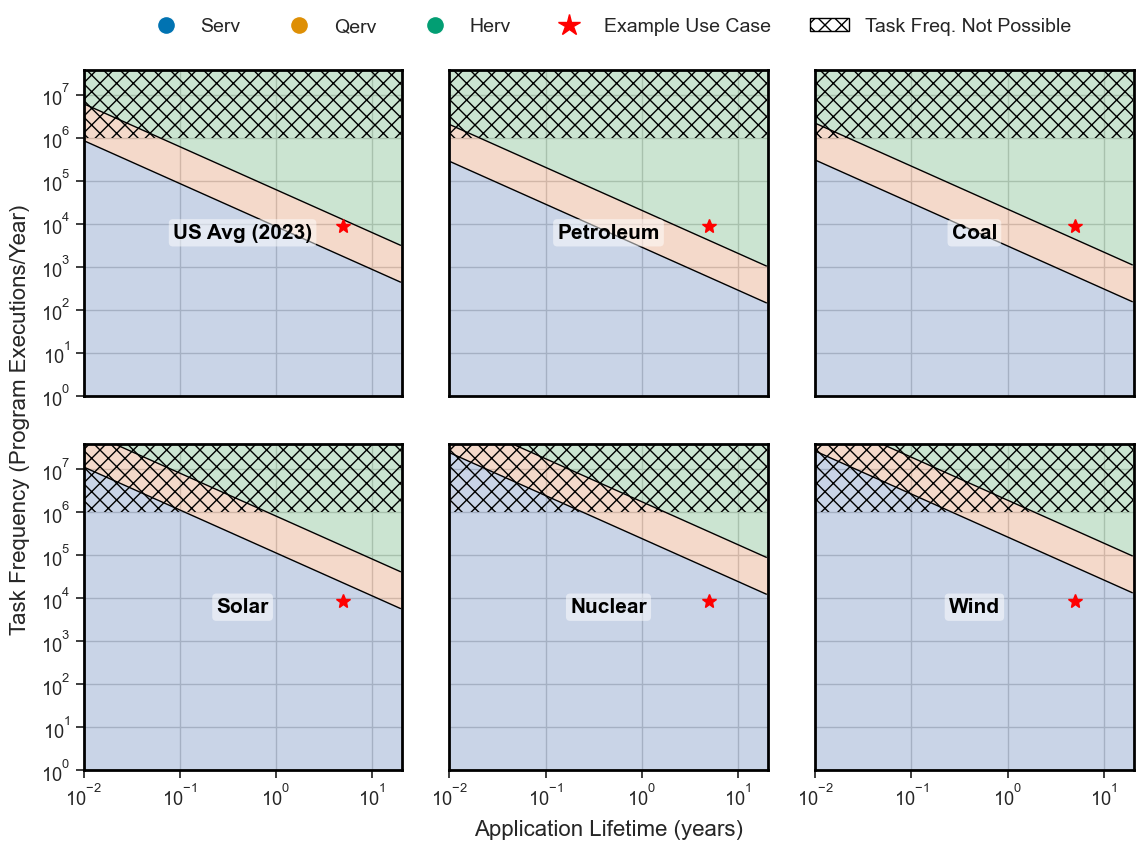

In [19]:
def plot_air_pollution_monitoring_carbon_ablation(
    carbon_intensities=None,
    core_freq=10000,
    workload_params={"lifetime_yrs": 5, "inf_freq": 365*24},
    output_pdf="plots/air_pollution_monitoring_carbon_ablation.pdf",
    ncols=3,
    nrows=2,
    title_wrap_width=16,
    hashes_grey=False,
    whitespace=0.15,
    show_plot=True
):
    """
    Creates a 3x2 grid of subplots for the Air Pollution Monitoring workload,
    varying only the carbon intensity in each subplot.
    Uses the carbon intensities from carbon_intensity_values and labels the plots accordingly.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import textwrap
    import os

    # Use the carbon intensities from carbon_intensity_values if not provided
    global carbon_intensity_values
    if carbon_intensities is None:
        # Use the values in the order of the keys
        carbon_intensities = [carbon_intensity_values[k] for k in carbon_intensity_values.keys()]
        carbon_intensity_labels = list(carbon_intensity_values.keys())
    else:
        # If user provides, just use those and label as "Custom"
        carbon_intensity_labels = [f"Custom ({v} gCO₂/kWh)" for v in carbon_intensities]

    sns.set_theme(style="whitegrid", font_scale=1.2, rc={"axes.facecolor": "white"})
    n = len(carbon_intensities)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(3.5 * ncols, 3.5 * nrows),
        gridspec_kw=dict(wspace=whitespace, hspace=whitespace)
    )
    axes = axes.flatten()

    workload = "Air Pollution Monitoring"
    for i, (carbon_intensity, label) in enumerate(zip(carbon_intensities, carbon_intensity_labels)):
        if i >= len(axes):
            break
        ax = axes[i]
        # Remove axis labels for all subplots
        ax.set_xlabel("")
        ax.set_ylabel("")
        row = i // ncols
        col = i % ncols

        ax.tick_params(labelleft=False, labelbottom=False)
        if whitespace == 0:
            if col == 0 and row == nrows-1:
                ax.tick_params(labelleft=True, labelbottom=True, left=True, bottom=True)
        else:
            if col == 0:
                ax.tick_params(labelleft=True, left=True)
            if row == nrows-1:
                ax.tick_params(labelbottom=True, bottom=True)

        lifetime_yrs = workload_params.get("lifetime_yrs", 1)
        inf_freq = workload_params.get("inf_freq", 1)
        x, y, mask = plot_best_system_region_map_ax(
            ax=ax,
            workload_choice=workload,
            lifetime_yrs=lifetime_yrs,
            inf_freq=inf_freq,
            carbon_intensity=carbon_intensity,
            core_freq=core_freq,
            hashes_grey=hashes_grey
        )
        # Title: show carbon intensity label and value
        wrapped_title = "\n".join(textwrap.wrap(f"{label}", width=title_wrap_width))
        ax.text(
            0.5, 0.5, wrapped_title,
            transform=ax.transAxes,
            ha='center', va='center',
            fontsize=15, fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2')
        )
        # Remove legend from all subplots
        ax.legend().remove()
        # Add a visible border to each subplot
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
            spine.set_color('black')

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    for ax in axes:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

    # Shared x/y labels
    fig.supxlabel("Application Lifetime (years)", fontsize=16, x=0.5, y=-0.1)
    fig.supylabel("Task Frequency (Program Executions/Year)", fontsize=16, x=-0.07, y=0.5)

    # Legend (same as in example)
    palette = sns.color_palette("colorblind", n_colors=len(system_colors))
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=13, label=system)
        for i, system in enumerate(system_colors.keys())
    ]
    legend_handles.append(
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markeredgecolor='red', markersize=16, label="Example Usecase")
    )
    crosshatch_patch = mpatches.Patch(facecolor='grey' if hashes_grey else 'none', hatch='xx', label='Task Freq. Not Possible', edgecolor='black')
    legend_handles.append(crosshatch_patch)
    legend_labels = list(system_colors.keys()) + ["Example Use Case", "Task Freq. Not Possible"]
    fig.legend(
        legend_handles, legend_labels,
        loc='upper center', ncol=len(legend_labels),
        bbox_to_anchor=(0.5, 1.1), fontsize=14, frameon=False
    )

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    plt.tight_layout(pad=0)

    if output_pdf:
        os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
        plt.savefig(output_pdf, format="pdf", bbox_inches='tight')
    if show_plot:
        plt.show()
    plt.close(fig)

plot_air_pollution_monitoring_carbon_ablation()